In [27]:
from copy import deepcopy
import numpy as np
import pandas as pd
import random

import matplotlib.pyplot as plt

from keras.layers import Input, Dense
from keras.models import Model

# Import modules from libs/ directory
from libs.pconv_layer import PConv2D
from libs.util import random_mask

%matplotlib inline
%load_ext autoreload
%autoreload 2
plt.rcParams['figure.figsize'] = (9.0, 9.0) # 设置figure_size尺寸

from matplotlib.font_manager import FontProperties
font = FontProperties(fname=r"c:\windows\fonts\STSong.TTF")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
matrix_df = pd.read_csv('./data/trafficV201306_M.csv', index_col=0, parse_dates=True)
matrix_df.shape

(2880, 1024)

8.0


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


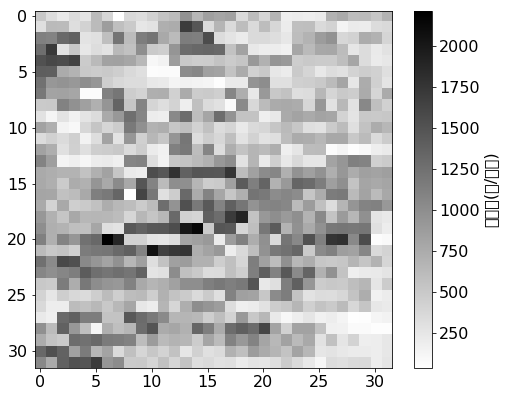

In [46]:
num = 96*3+32#random.randint(0, matrix_df.shape[0])
pic_matrix = matrix_df.iloc[num].values.reshape(32, 32, 1)
# pic_matrix = (pic_matrix - pic_matrix.min())/(pic_matrix.max() - pic_matrix.min())*255
print((num%96)*15/60)
from pylab import mpl
mpl.rcParams['font.serif'] = ['SimSun'] 

# plt.imshow(pic_matrix[:,:,0], cmap='gray')
fig, axe = plt.subplots(1, 1, figsize=(8, 8))
img = axe.imshow(pic_matrix[:,:,0], cmap ='binary')
cb = fig.colorbar(img, shrink=0.82, label='交通量(辆/小时)')
mpl.rcParams['font.serif'] = ['SimSun'] 
plt.rcParams.update({'font.size': 16})
# plt.savefig('6.3_8点交通矩阵_黑白.jpg', dpi=300)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  


8.0


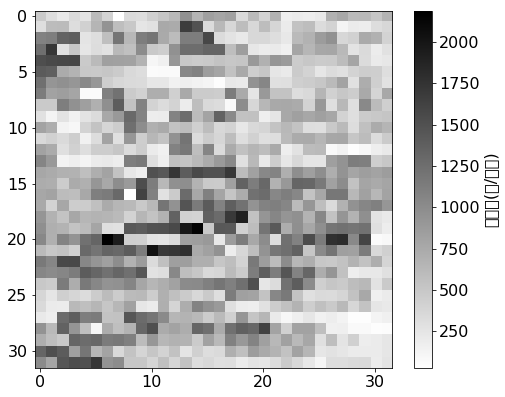

In [31]:
num = 96*4+32#random.randint(0, matrix_df.shape[0])
pic_matrix = matrix_df.iloc[num].reshape(32, 32, 1)
# pic_matrix = (pic_matrix - pic_matrix.min())/(pic_matrix.max() - pic_matrix.min())*255
print((num%96)*15/60)

# plt.imshow(pic_matrix[:,:,0], cmap='gray')
fig, axe = plt.subplots(1, 1, figsize=(8, 8))
img = axe.imshow(pic_matrix[:,:,0], cmap ='binary')
cb = fig.colorbar(img, shrink=0.82, label='交通量(辆/小时)')
from pylab import mpl
mpl.rcParams['font.serif'] = ['SimSun'] 
plt.rcParams.update({'font.size': 18})
plt.savefig('6.3_8点交通矩阵_黑白.jpg', dpi=300)

In [5]:
# ??random_mask

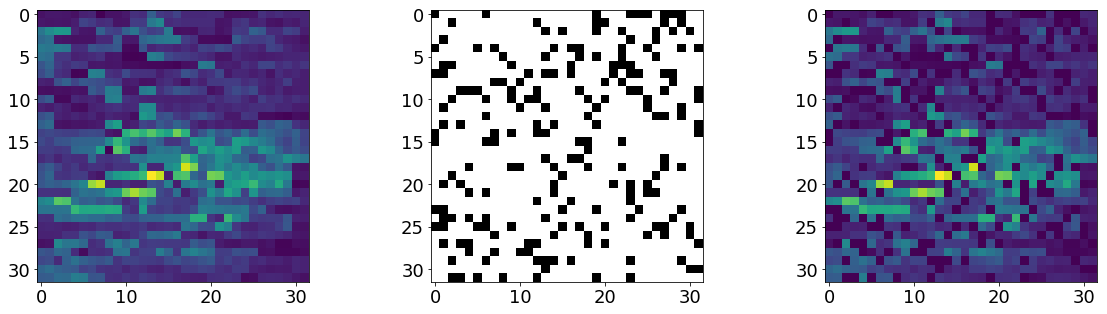

In [6]:
pic_shape = pic_matrix.shape
# Load mask
mask = random_mask(pic_shape[0], pic_shape[1], size=0.2)
# mask = random_mask(pic_shape[0], pic_shape[1], size=0.9, type='block', block_size=(15, 15))

# Image + mask
masked_img = deepcopy(pic_matrix)
# masked_img = (pic_matrix - pic_matrix.min())/(pic_matrix.max() - pic_matrix.min())*255

masked_img[mask==0] = np.min(masked_img)

# Show side by side
_, axes = plt.subplots(1, 3, figsize=(20, 5))
axes[0].imshow(pic_matrix[:,:,0])
axes[1].imshow(mask[:,:,0]*255, cmap ='gray')
axes[2].imshow(masked_img[:,:,0])

In [7]:
pic_shape

(32, 32, 1)

In [8]:
# Input images and masks
input_img = Input(shape=(pic_shape[0], pic_shape[1], pic_shape[2],))
input_mask = Input(shape=(pic_shape[0], pic_shape[1], pic_shape[2],))
output_img, output_mask1 = PConv2D(8, kernel_size=(3,3), strides=(2,2), padding='same')([input_img, input_mask])
output_img, output_mask2 = PConv2D(16, kernel_size=(3,3), strides=(2,2), padding='same')([output_img, output_mask1])
output_img, output_mask3 = PConv2D(32, kernel_size=(3,3), strides=(2,2), padding='same')([output_img, output_mask2])
# output_img, output_mask4 = PConv2D(64, kernel_size=(3,3), strides=(2,2))([output_img, output_mask3])

# Create model
model = Model(
    inputs=[input_img, input_mask], 
    outputs=[
        output_img, output_mask1, output_mask2, output_mask3
    ])
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

# Show summary of the model
# model.summary()

Check mask layer updates

In [9]:
formatted_img = np.expand_dims(masked_img, axis=0)
formatted_mask = np.expand_dims(mask, axis=0)
print(f"Original Mask Shape: {formatted_mask.shape} - Max value in mask: {np.max(formatted_mask)}")

output_img, o1, o2, o3 = model.predict([formatted_img, formatted_mask])

Original Mask Shape: (1, 32, 32, 1) - Max value in mask: 1


In [10]:
o3.shape

(1, 4, 4, 32)

Text(0.5,1,'Shape: (1, 4, 4, 32)')

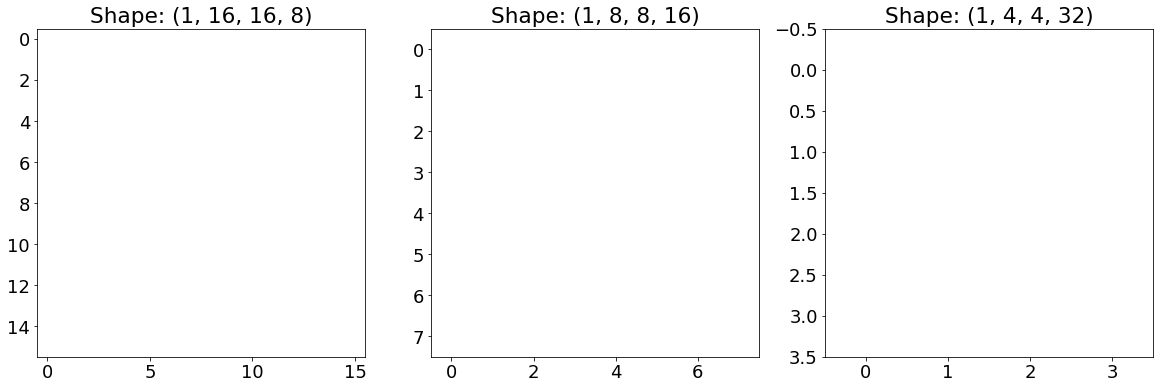

In [11]:
_, axes = plt.subplots(1, 3, figsize=(20, 10))
axes[0].imshow(o1[0, :,:, 0], cmap = 'gray', vmin=0, vmax=1)
axes[1].imshow(o2[0, :,:, 0], cmap = 'gray', vmin=0, vmax=1)
axes[2].imshow(o3[0, :,:, 0], cmap = 'gray', vmin=0, vmax=1)

axes[0].set_title(f"Shape: {o1.shape}")
axes[1].set_title(f"Shape: {o2.shape}")
axes[2].set_title(f"Shape: {o3.shape}")
